In [1]:
import numpy as np
import glob, os
import xarray as xr
import pandas as pd
import time, datetime, calendar, pytz
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
%matplotlib inline

In [2]:
# datadir = '/global/cscratch1/sd/feng045/waccem/MERGIR_Global/stats/'
datadir = '/global/project/projectdirs/m1867/zfeng/gpm/MERGIR_Global/stats/'
datafiles = sorted(glob.glob(f'{datadir}merg_monthly_validcount_*nc'))
# datafiles = sorted(glob.glob(f'{datadir}merg_monthly_validcount_2015*nc'))

print(len(datafiles))

figdir = datadir

66


In [3]:
# Read data
# ds = xr.open_mfdataset(datafiles, concat_dim='time')
ds = xr.open_mfdataset(datafiles, concat_dim='time', combine='by_coords')
# ds.load()
ds

<xarray.Dataset>
Dimensions:       (lat: 3298, lon: 9896, time: 66)
Coordinates:
  * lat           (lat) float32 -59.981808 -59.945423 ... 59.945423 59.981808
  * lon           (lon) float32 -179.98181 -179.94543 ... 179.94543 179.98181
  * time          (time) datetime64[ns] 2014-01-01 2014-02-01 ... 2019-06-01
Data variables:
    count_00min   (time, lat, lon) float32 dask.array<chunksize=(1, 3298, 9896), meta=np.ndarray>
    count_30min   (time, lat, lon) float32 dask.array<chunksize=(1, 3298, 9896), meta=np.ndarray>
    ntimes_00min  (time) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    ntimes_30min  (time) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    ntimes        (time) int32 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    title:       Valid data counts
    contact:     Zhe Feng, zhe.feng@pnnl.gov
    created_on:  Tue Feb 26 17:06:35 2019

In [4]:
lon = ds.lon
lat = ds.lat
ntimes = ds.ntimes

In [5]:
frac00_all = ds.count_00min.sum(dim='time') / ds.ntimes_00min.sum(dim='time')
frac30_all = ds.count_30min.sum(dim='time') / ds.ntimes_30min.sum(dim='time')

In [6]:
ds.ntimes_00min.groupby('time.year').sum(dim='time')

<xarray.DataArray 'ntimes_00min' (year: 6)>
dask.array<stack, shape=(6,), dtype=int64, chunksize=(1,)>
Coordinates:
  * year     (year) int64 2014 2015 2016 2017 2018 2019

In [7]:
frac00_year = ds.count_00min.groupby('time.year').sum(dim='time') / ds.ntimes_00min.groupby('time.year').sum(dim='time')
frac30_year = ds.count_30min.groupby('time.year').sum(dim='time') / ds.ntimes_30min.groupby('time.year').sum(dim='time')
years = frac00_year.year

In [8]:
# fig = plt.figure(figsize=[10,3], dpi=100)
# (frac00_all*100).plot.pcolormesh(norm=mpl.colors.PowerNorm(gamma=1./2.), cmap='Spectral')

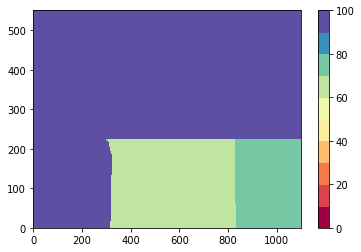

In [9]:
tmp = frac00_all.sel(lon=slice(120,160),lat=slice(-10,10))
levels = np.arange(0, 100.1, 10)
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=256)
# plt.pcolormesh(tmp*100, norm=mpl.colors.PowerNorm(gamma=1./2.), vmin=0, vmax=80, cmap='Spectral')
plt.pcolormesh(tmp*100, norm=norm, cmap='Spectral')
plt.colorbar()

In [10]:
ds.lon.min(), ds.lon.max(), ds.lat.min(), ds.lat.max()

(<xarray.DataArray 'lon' ()>
 array(-179.98181, dtype=float32), <xarray.DataArray 'lon' ()>
 array(179.98181, dtype=float32), <xarray.DataArray 'lat' ()>
 array(-59.981808, dtype=float32), <xarray.DataArray 'lat' ()>
 array(59.981808, dtype=float32))

In [14]:
def plot_2maps(dataarray, levels, cmap, cblabel, cbticks, titles, figname):
    
    mpl.rcParams['font.size'] = 13
    mpl.rcParams['font.family'] = 'Helvetica'

    map_extend = [-180, 180.1, -60, 60.1]
    lonvals = mpl.ticker.FixedLocator(np.arange(-180,180.1,60))
    latvals = mpl.ticker.FixedLocator(np.arange(-60,60.1,20))
    levelshgt = [1000,2000]
#     titles = ['00 min', '30 min']

    fig = plt.figure(figsize=[10,7], dpi=100)

    land = cfeature.NaturalEarthFeature('physical', 'land', '110m')
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '110m')
    borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', '110m')
    fig = plt.figure(figsize=[10,7], dpi=100)

    for pp in range(0,2):
        data = dataarray[pp]

        ax = plt.subplot(2, 1, pp+1, projection=ccrs.PlateCarree())
        ax.set_extent(map_extend, crs=ccrs.PlateCarree())
#         ax.add_feature(ocean, edgecolor='k', facecolor=cfeature.COLORS['water'])
#         ax.add_feature(borders, edgecolor='k', facecolor='none', linewidth=1, zorder=5)
        ax.add_feature(land, facecolor='none', edgecolor='k', zorder=5)

        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--', linewidth=0.5)
        gl.xlabels_top = False
        gl.ylabels_right = False
        gl.xlocator = lonvals
        gl.ylocator = latvals
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER

        Zm = np.ma.masked_where(((data == 0) | (np.isnan(data))), data)
        norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=256)
#         norm = mpl.colors.PowerNorm(gamma=1./2.)
        cf1 = plt.pcolormesh(lon, lat, Zm, norm=norm, vmin=np.min(levels), vmax=np.max(levels), cmap=cmap, transform=ccrs.PlateCarree())
#         cf1 = plt.contourf(lon, lat, Zm, levels=levels, cmap=cmap, transform=ccrs.PlateCarree(), zorder=2, extend='both')
        ax.set_title(titles[pp], loc='left')
        plt.colorbar(cf1, label=cblabel, pad=0.02, ticks=cbticks)
        ax.set_aspect('auto', adjustable=None)

#         # Terrain height
#         ct = ax.contour(lon_hgt, lat_hgt, hgt_s, levels=levelshgt, \
#                         colors='dimgray', linewidths=(1.0,1.5), transform=ccrs.PlateCarree(), zorder=6)
#         ctlb = ax.clabel(ct, inline=True, fmt='%.0f', fontsize=10)

#     plt.tight_layout(w_pad=2.5, h_pad=1.2)
    plt.tight_layout()
    fig.savefig(figname, dpi=300, bbox_inches='tight')
    return fig

/global/homes/f/feng045/envs/py37/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


<Figure size 1000x700 with 0 Axes>

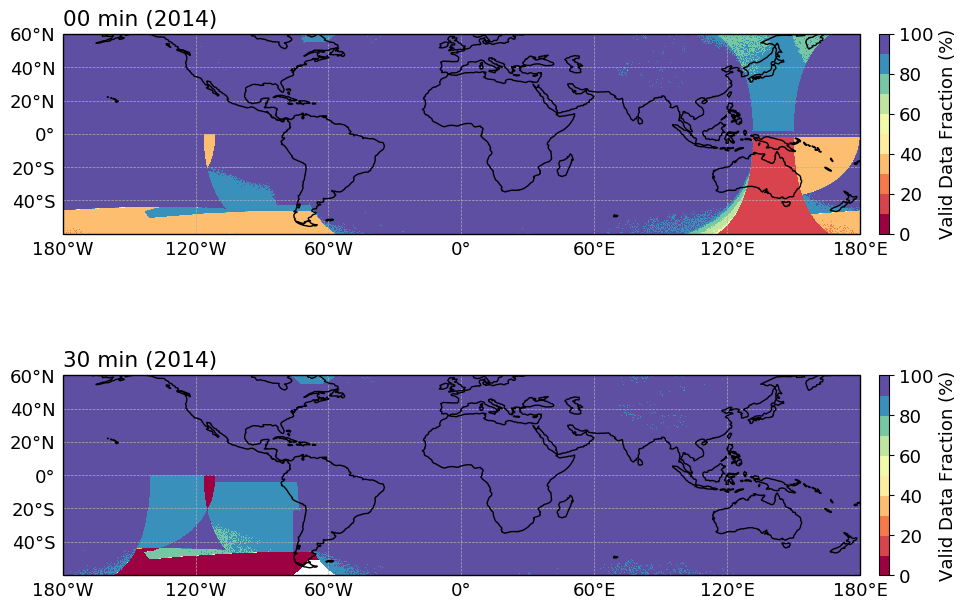

<Figure size 1000x700 with 0 Axes>

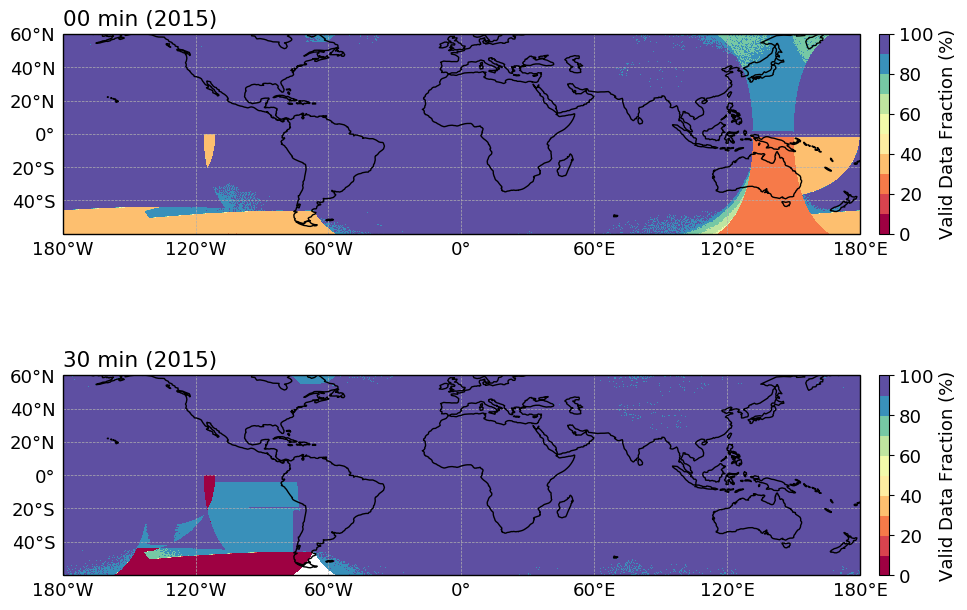

<Figure size 1000x700 with 0 Axes>

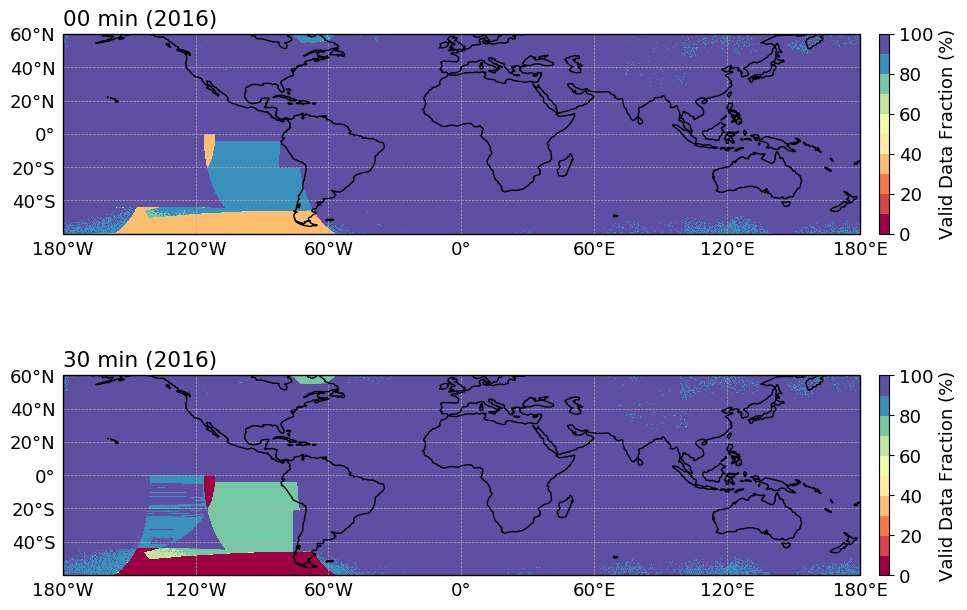

<Figure size 1000x700 with 0 Axes>

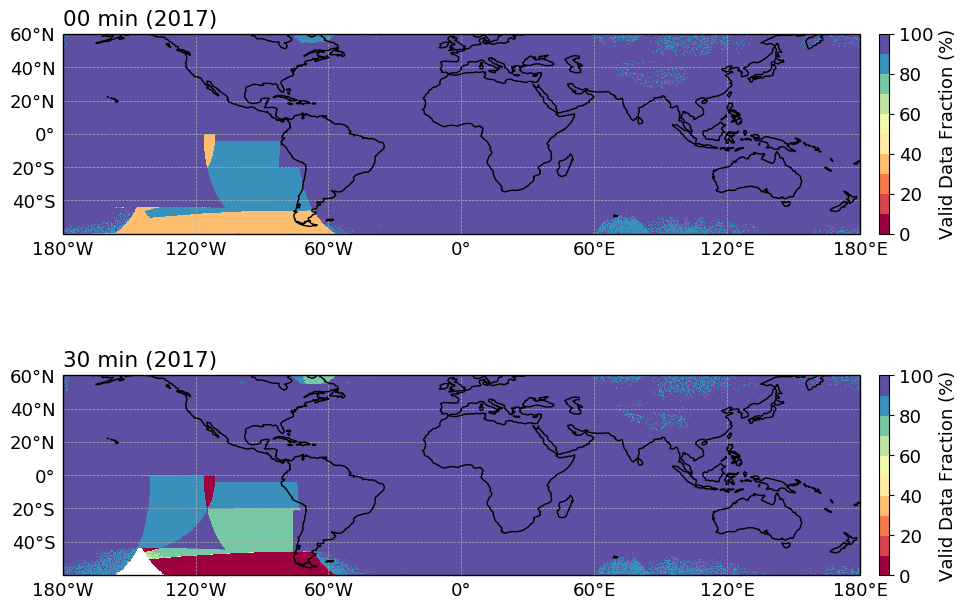

<Figure size 1000x700 with 0 Axes>

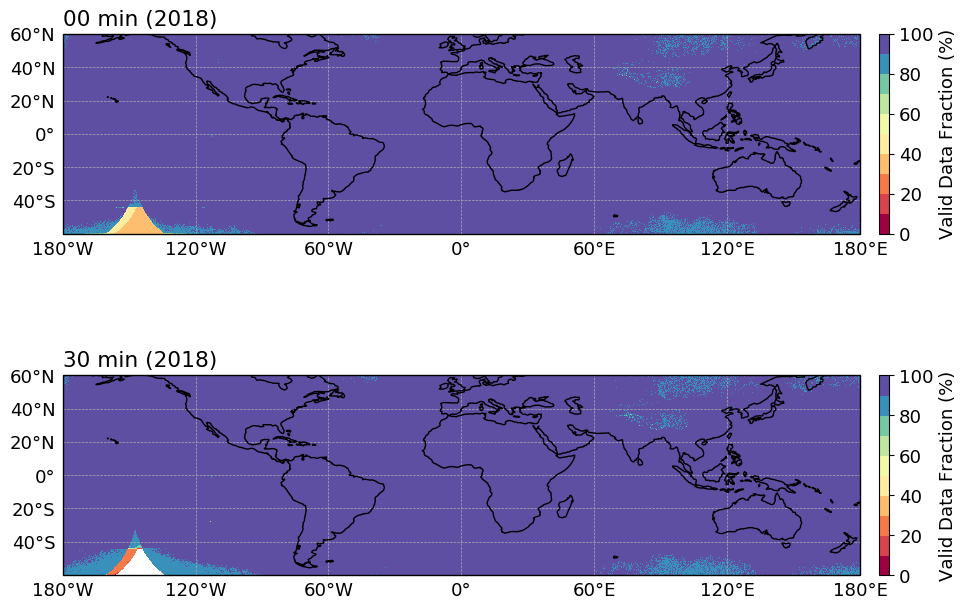

<Figure size 1000x700 with 0 Axes>

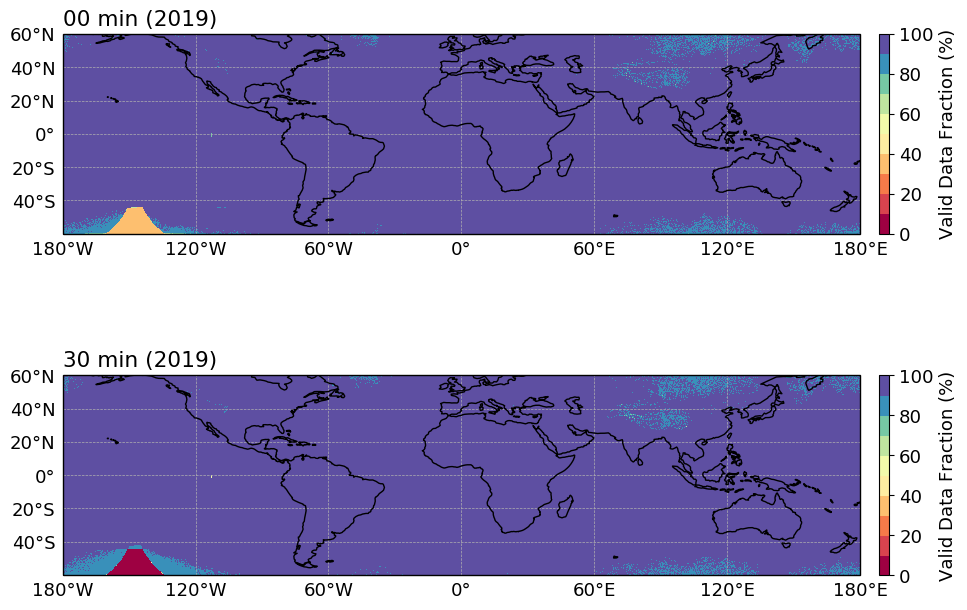

In [12]:
levels = np.arange(0, 100.1, 10)
cbticks = np.arange(0, 100.1, 20)
cblabel = 'Valid Data Fraction (%)'
cmap = 'Spectral'

# Loop over each year
for ii, iyear in enumerate(years):
#     print(iyear.values)
#     print(years.values[ii])
#     print(frac00_year.sel(year=years.values[ii]).shape)
    titles = [f'00 min ({iyear.values})', f'30 min ({iyear.values})']
    figname = f'{figdir}merg_validdata_frac_{iyear.values}.png'
    dataarr = [frac00_year.sel(year=iyear)*100, frac30_year.sel(year=iyear)*100]
    fig = plot_2maps(dataarr, levels, cmap, cblabel, cbticks, titles, figname)

<Figure size 1000x700 with 0 Axes>

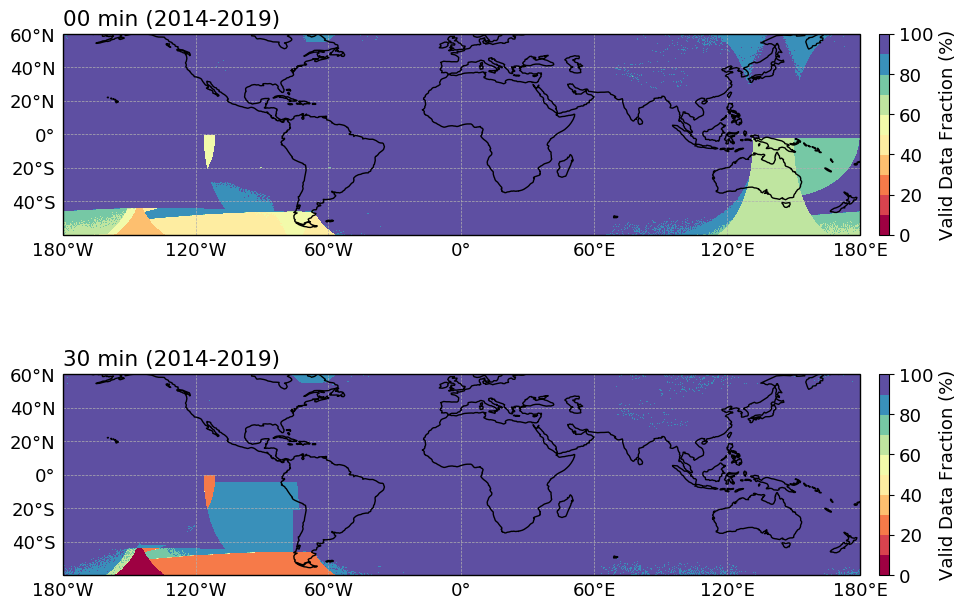

In [15]:
dataarr = [frac00_all*100, frac30_all*100]
levels = np.arange(0, 100.1, 10)
cbticks = np.arange(0, 100.1, 20)
cblabel = 'Valid Data Fraction (%)'
cmap = 'Spectral'
titles = ['00 min (2014-2019)', '30 min (2014-2019)']
figname = figdir + 'merg_validdata_frac_2014-2019.png'
fig = plot_2maps(dataarr, levels, cmap, cblabel, cbticks, titles, figname)